## Valorant Average Combat Score Prediction Using Dense Neural Network Based on Match Metrics

**Proponents:** *Alforque, Batalan, Verdan*

### Phase 1: Pre-processing

#### Import modules

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from datetime import datetime


#### Define path

In [30]:
DATASET_PATH = "data/overview.csv"
df = pd.read_csv(DATASET_PATH)
df = df.dropna(subset=['rating', 'acs'])
df.isna().any()
df.shape[0]

66644

#### Extract labels

In [8]:
y = df['rating'].values
y

array([1.6 , 1.71, 1.52, ..., 0.84, 1.12, 0.57])

#### Select features

In [ ]:
features = ['acs','kills','deaths','assists','kast_percent','adpr','headshot_percent','firstkill','firstdeath','side']
X_raw = df[features].copy()
X_raw.head(5)

66644

#### Check for missing data

In [10]:
X_raw.isna().any()

acs                 False
kills               False
deaths              False
assists             False
kast_percent         True
adpr                 True
headshot_percent     True
firstkill           False
firstdeath          False
side                False
dtype: bool

#### Impute missing data

In [11]:
X_raw['kast_percent'].interpolate(method='linear', axis=0, inplace=True)
X_raw['adpr'].interpolate(method='linear', axis=0, inplace=True)
X_raw['headshot_percent'].interpolate(method='linear', axis=0, inplace=True)

C:\Users\hi\AppData\Local\Temp\ipykernel_5896\1585193515.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_raw['kast_percent'].interpolate(method='linear', axis=0, inplace=True)
C:\Users\hi\AppData\Local\Temp\ipykernel_5896\1585193515.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [12]:
X_raw.isna().any()

acs                 False
kills               False
deaths              False
assists             False
kast_percent        False
adpr                False
headshot_percent    False
firstkill           False
firstdeath          False
side                False
dtype: bool

#### Split data

In [13]:
train_X_raw, test_X_raw, train_y, test_y = train_test_split(X_raw, y, test_size=0.2, random_state=0)
print(f'train_X_raw: {train_X_raw.shape}')
print(f'test_X_raw: {test_X_raw.shape}')
print(f'train_y: {train_y.shape}')
print(f'test_y: {test_y.shape}')

train_X_raw: (53315, 10)
test_X_raw: (13329, 10)
train_y: (53315,)
test_y: (13329,)


In [14]:
train_X_raw

,acs,kills,deaths,assists,kast_percent,adpr,headshot_percent,firstkill,firstdeath,side
65217,154.0,10.0,16.0,1.0,0.71,98.0,0.28,1.0,4.0,both
30623,106.0,8.0,11.0,8.0,0.61,90.0,0.32,1.0,4.0,defend
59024,204.0,6.0,3.0,1.0,1.00,128.0,0.06,0.0,0.0,defend
59314,115.0,5.0,10.0,2.0,0.50,65.0,0.23,0.0,0.0,attack
696,263.0,21.0,16.0,2.0,0.89,166.0,0.33,3.0,5.0,both
...,...,...,...,...,...,...,...,...,...,...
42005,153.0,6.0,7.0,3.0,0.67,96.0,0.38,0.0,2.0,defend
21248,215.0,11.0,10.0,1.0,0.77,149.0,0.26,0.0,0.0,defend
45909,255.0,21.0,12.0,2.0,0.82,162.0,0.36,3.0,1.0,both
42626,182.0,14.0,9.0,8.0,0.83,135.0,0.17,2.0,1.0,defend


#### Define encoders

In [15]:
encoders = ColumnTransformer([
    ('scaler', RobustScaler(), ['acs','kills','deaths','assists','kast_percent','adpr','headshot_percent','firstkill','firstdeath']),
    ('ohe',OneHotEncoder(), ['side'])
])

#### Encode training data

In [16]:
train_X = encoders.fit_transform(train_X_raw)

In [17]:
train_X

array([[-0.46987952, -0.09090909,  0.55555556, ...,  0.        ,
         1.        ,  0.        ],
       [-1.04819277, -0.27272727,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13253012, -0.45454545, -0.88888889, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.74698795,  0.90909091,  0.11111111, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13253012,  0.27272727, -0.22222222, ...,  0.        ,
         0.        ,  1.        ],
       [-0.09638554, -0.18181818, -0.22222222, ...,  1.        ,
         0.        ,  0.        ]])

In [18]:
train_X.shape

(53315, 12)

#### Encode test data

In [19]:
test_X = encoders.transform(test_X_raw)

In [20]:
test_X.shape

(13329, 12)

### Phase II: Neural Network Architecture and Rationale

#### Create Keras model

In [21]:
input_ = tf.keras.layers.Input(shape=(12,))
dense1 = tf.keras.layers.Dense(128, activation='relu')(input_)
reg1 = dense1
reg1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(512, activation='relu')(reg1)
dense3 = tf.keras.layers.Dense(256, activation='relu')(dense2)
dense4 = tf.keras.layers.Dense(128, activation='relu')(dense3)
reg2 = dense4
reg2 = tf.keras.layers.BatchNormalization()(dense4)
dense5 = tf.keras.layers.Dense(64, activation='relu')(reg2)
output = tf.keras.layers.Dense(1, activation='linear')(dense5)

In [22]:
model = tf.keras.Model(inputs=input_, outputs=output)

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,281 (942.50 KB)

 Trainable params: 240,769 (940.50 KB)

 Non-trainable params: 512 (2.00 KB)

### Phase III: Training Methods

#### Compile model

In [24]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['root_mean_squared_error','mean_absolute_error', 'mean_absolute_percentage_error','r2_score'
    ]
)

#### Define early stop

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

#### Define model checkpoint

In [26]:
MODEL_PATH = 'finalprojcheckpoint2/checkpoints_it_9/model_at_{epoch:02d}.keras'
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH)

#### Train model

In [27]:
training_history = model.fit(train_X, train_y, batch_size=64, epochs=50, validation_split=0.2, callbacks=[early_stop, model_checkpoint])

Epoch 1/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.1204 - mean_absolute_error: 0.2276 - mean_absolute_percentage_error: 33.4353 - r2_score: 0.0791 - root_mean_squared_error: 0.3238 - val_loss: 0.0323 - val_mean_absolute_error: 0.1336 - val_mean_absolute_percentage_error: 18.8045 - val_r2_score: 0.7682 - val_root_mean_squared_error: 0.1797
Epoch 2/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0345 - mean_absolute_error: 0.1376 - mean_absolute_percentage_error: 21.1995 - r2_score: 0.7462 - root_mean_squared_error: 0.1857 - val_loss: 0.0245 - val_mean_absolute_error: 0.1156 - val_mean_absolute_percentage_error: 17.0540 - val_r2_score: 0.8242 - val_root_mean_squared_error: 0.1565
Epoch 3/50
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0287 - mean_absolute_error: 0.1261 - mean_absolute_percentage_error: 19.2643 - r2_score: 0.7829 - root_mean_squared_error: 0.1694 - val_loss: 0.0275 - val_mean_absolute_error: 0.1216 - val_mean_absolute_percentage_error: 19.2930 - va

KeyboardInterrupt: 

#### Save model

In [ ]:
SAVED_MODEL_PATH = 'finalprojcheckpoint2/checkpoints_it_9/model.keras'
model.save(SAVED_MODEL_PATH)

### Phase IV: Post Processing

#### Load and verify model

In [ ]:
saved_model = tf.keras.models.load_model(SAVED_MODEL_PATH)
saved_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,821 (2.76 MB)

 Trainable params: 240,769 (940.50 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 481,540 (1.84 MB)

#### Consume best model

In [ ]:
test_y_pred = saved_model.predict(test_X)

417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
results = saved_model.evaluate(test_X, test_y, verbose=1)

417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.1003 - mean_absolute_percentage_error: 15.4018 - r2_score: 0.8561 - root_mean_squared_error: 0.1388


#### Plot model

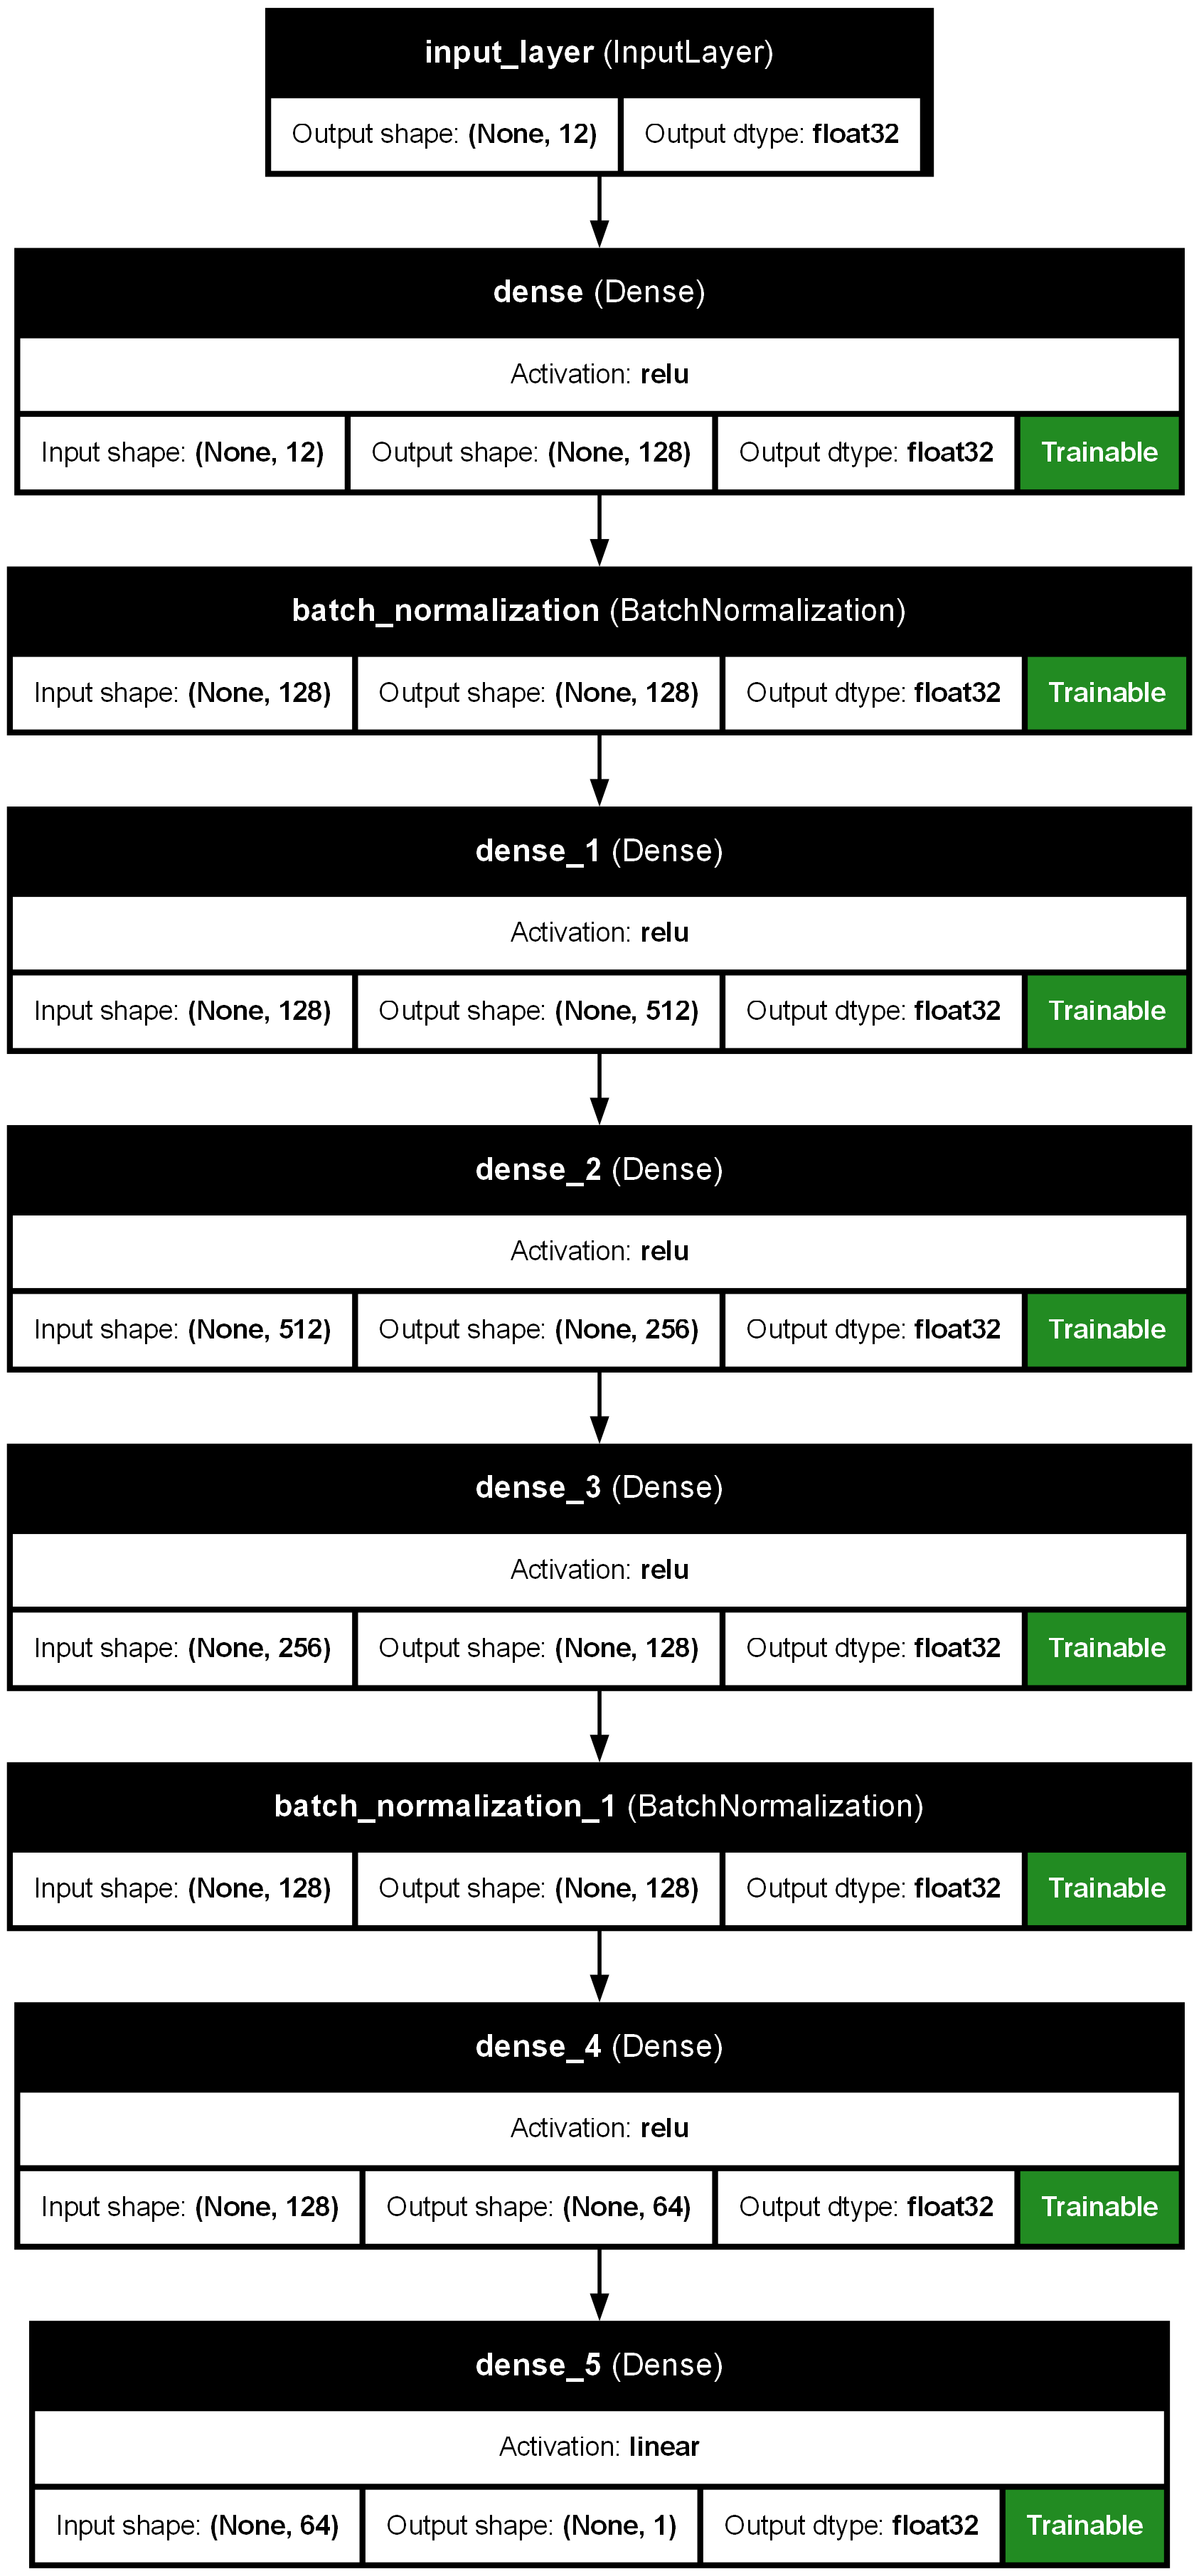

In [ ]:
img_file = 'finalprojcheckpoint2/checkpoints_it_9/model.png'
tf.keras.utils.plot_model(model, to_file=img_file, dpi=200, show_shapes=True, show_dtype=True, show_layer_names=True,show_layer_activations=True, show_trainable=True)